In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random

import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.transforms import ToTensor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [70]:
seed = 42

random.seed(seed)
torch_seed = random.randint(0, 2 ** 32 - 1)
numpy_seed = random.randint(0, 2 ** 32 - 1)
torch.manual_seed(torch_seed)
torch.cuda.manual_seed(torch_seed)
np.random.seed(numpy_seed)

In [71]:
class Autoencoder(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Linear(10, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 10),
            nn.ReLU(),
            nn.Linear(10, input_size)
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)
    
    def clasiffy(self, x):
        return self.encoder(x)

In [72]:
n = 15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [73]:
def load_data(n: int):
    X = np.load('Datasets/kryptonite-%s-X.npy'%(n))
    y = np.load('Datasets/kryptonite-%s-y.npy'%(n))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test

def convert_to_tensor_dataset(X, y):
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    X = X.to(device)
    y = y.to(device)
    return torch.utils.data.TensorDataset(X, y)

In [74]:
X_train, y_train, X_test, y_test = load_data(n)

In [75]:
def train_and_test(net, train_dataset, num_epochs):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.005)

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=2048, shuffle=True)

    for epoch in range(num_epochs):
        epoch_train_loss = []
        for i, (inputs, _) in enumerate(trainloader):
            net.zero_grad()
            
            outputs = net(inputs)
            loss = loss_fn(outputs, inputs)
            epoch_train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        
        if epoch % 5 == 0:
            print('Epoch:', epoch + 1, 'Loss:', np.mean(epoch_train_loss))

    return net

def plot_losses(net, X_train, y_train):
    net = net.to('cpu')
    with torch.no_grad():
        plt.scatter(net.clasiffy(X_train).numpy()[:, 0], net.clasiffy(X_train).numpy()[:, 1], c=y_train)

    plt.show()

In [76]:
net = Autoencoder(n).to(device)

train_and_test(net, convert_to_tensor_dataset(X_train, y_train), 2000)

Epoch: 1 Loss: 1.0460362037022908
Epoch: 6 Loss: 0.9463793188333511
Epoch: 11 Loss: 0.883548746506373
Epoch: 16 Loss: 0.8682446132103602
Epoch: 21 Loss: 0.8652826994657516
Epoch: 26 Loss: 0.8592323412497839
Epoch: 31 Loss: 0.8262138466040293
Epoch: 36 Loss: 0.8104389856259028
Epoch: 41 Loss: 0.8067595064640045
Epoch: 46 Loss: 0.8045090486605962
Epoch: 51 Loss: 0.8030406335989634
Epoch: 56 Loss: 0.801861842473348
Epoch: 61 Loss: 0.80092021326224
Epoch: 66 Loss: 0.8006510933240255
Epoch: 71 Loss: 0.7999925017356873
Epoch: 76 Loss: 0.7993845442930857
Epoch: 81 Loss: 0.7991713335116705
Epoch: 86 Loss: 0.79855877161026
Epoch: 91 Loss: 0.7981920639673868
Epoch: 96 Loss: 0.7968160957098007
Epoch: 101 Loss: 0.7947157273689905
Epoch: 106 Loss: 0.7891196956237158
Epoch: 111 Loss: 0.7835845549901327
Epoch: 116 Loss: 0.7787059942881266
Epoch: 121 Loss: 0.7745243459939957
Epoch: 126 Loss: 0.7728210836648941
Epoch: 131 Loss: 0.7699863861004511
Epoch: 136 Loss: 0.7693067342042923
Epoch: 141 Loss: 0.7

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=15, bias=True)
  )
)

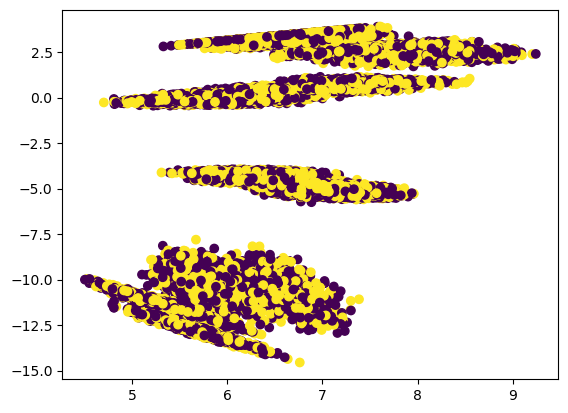

In [77]:
plot_losses(net, torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))